To reproduce ASIC AE EMD Pipeline results

In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import numba
import math

from utils.metrics import emd
from utils.metrics import hexMetric

import scipy
from scipy import stats, optimize, interpolate


from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, BatchNormalization, Activation, Average, Conv2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.regularizers import l1_l2
        
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras import backend as K

from datetime import date

In [2]:
def load_data(inputFile):
    data=pd.read_csv(inputFile,usecols=[*range(0,48)])
    data_values=data.values
            
    return data_values

def load_eta(inputFile):
    data=pd.read_csv(inputFile,usecols=[48])
    data_values=data.to_numpy().flatten()
            
    return data_values

In [29]:
#Make new image directory for today's updates

today = date.today().strftime("%m_%d_%y")

img_directory=os.path.join('/ecoderemdvol/paper_plots/{}').format(today)

if not os.path.exists(img_directory):
    os.makedirs(img_directory)

In [31]:
test_1='/ecoderemdvol/EleGun/low_pt_high_eta/AE/ae_tele/8x8_c8_S2_tele/verify_input_calQ.csv'
test_2='/ecoderemdvol/EleGun/low_pt_high_eta/AE/ae_tele/8x8_c8_S2_tele/verify_decoded_calQ.csv'

arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])

In [32]:
calQ1     = load_data(test_1)
sumQ1     = calQ1.sum(axis=1)
calQ1     = calQ1[sumQ1>0]
sumQ1     = sumQ1[sumQ1>0]

calQ1_443 = (calQ1/np.expand_dims(sumQ1,-1))[:,arrange443].reshape(-1,4,4,3)

calQ2     = load_data(test_2)
sumQ2     = calQ2.sum(axis=1)
calQ2     = calQ2[sumQ2>0]
sumQ2     = sumQ2[sumQ2>0]

calQ2_443 = (calQ2/np.expand_dims(sumQ2,-1))[:,arrange443].reshape(-1,4,4,3)

#Generate True EMD for validation section of dataset
test_index= int(0.7*len(calQ1))
test_indices = range(test_index, len(calQ1))

In [8]:
truth_emd = np.array([emd(calQ1[i],calQ2[j]) for i, j in zip(test_indices,test_indices)])

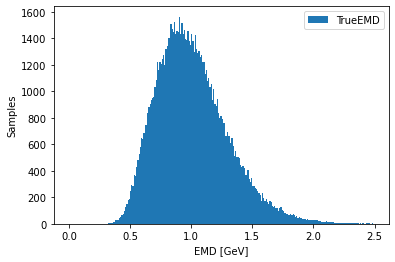

In [34]:
fig=plt.figure()
fig=plt.hist(truth_emd, alpha=1, bins=np.arange(0, 2.5,0.01), label='TrueEMD')
fig=plt.xlabel('EMD [GeV]')
fig=plt.ylabel('Samples')
fig=plt.legend()
plt.savefig(os.path.join(img_directory,'TrueEMD.png'))
plt.show()

In [35]:
#Load best emd model 

model_path='/ecoderemdvol/best_emd/ae_mse_lphe.h5'

In [39]:
X1 = calQ1_443
X2 = calQ2_443

X1_test = X1[test_index:]
X2_test = X2[test_index:]

model = tf.keras.models.load_model(model_path);

In [40]:
pred_emd = model.predict((X1_test, X2_test));

In [52]:
#Save data for later

emd_nn_data = pd.DataFrame(columns = ['truth','pred'])
emd_nn_data['truth'] = truth_emd
emd_nn_data['pred'] = pred_emd
emd_nn_data.to_csv('/ecoderemdvol/paper_plots/emd_nn_data.csv')

In [56]:
#Load saved data

emd_nn_data = pd.read_csv('/ecoderemdvol/paper_plots/emd_nn_data.csv')
truth_emd = emd_nn_data['truth'].values
pred_emd = emd_nn_data['pred'].values

In [ ]:
resolution = 100

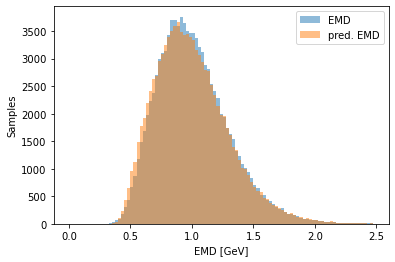

In [66]:
#Plots True EMD and Pred Emd Histogram
plt.close()  
fig=plt.figure()

#plt.xlim(-2.0,2.0)

fig=plt.hist(truth_emd, alpha=0.5, bins=np.arange(0, 2.5, 0.025), label='EMD')
fig=plt.hist(pred_emd, alpha=0.5, bins=np.arange(0, 2.5, 0.025), label='pred. EMD')
fig=plt.xlabel('EMD [GeV]')
fig=plt.ylabel('Samples')
fig=plt.legend()
plt.savefig(os.path.join(img_directory,'testing_EMD.pdf'),dpi=resolution)
plt.show()

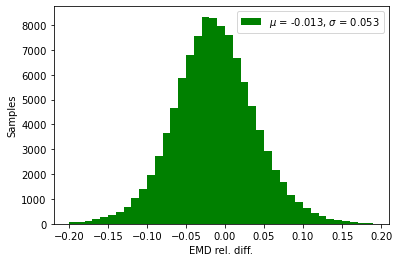

In [68]:
#Plot Relative Difference
plt.close()        
rel_diff = (pred_emd[pred_emd>0].flatten()-truth_emd[truth_emd>0].flatten())/truth_emd[truth_emd>0].flatten()
fig=plt.figure()
fig=plt.hist(rel_diff, bins=np.arange(-0.2, 0.2, 0.01), color='green', label = r'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(np.mean(rel_diff), np.std(rel_diff)))
fig=plt.xlabel('EMD rel. diff.')
fig=plt.ylabel('Samples')
fig=plt.legend()
plt.savefig(os.path.join(img_directory,'testing_RelD.pdf'),dpi=resolution)
plt.show()

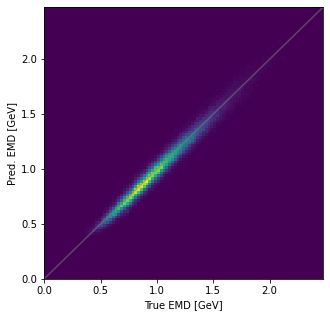

In [71]:
#Plot True EMD vs Pred Emd Graphic
plt.close()        
fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.arange(0, 2.5, 0.025)
y_bins = np.arange(0, 2.5, 0.025)
plt.hist2d(truth_emd.flatten(), pred_emd.flatten(), bins=[x_bins,y_bins])
plt.plot([0, 2.5], [0, 2.5], color='gray', alpha=0.5)
ax.set_xlabel('True EMD [GeV]')
ax.set_ylabel('Pred. EMD [GeV]')
plt.savefig(os.path.join(img_directory,'testing_Correl.pdf'),dpi=resolution)
plt.show()

Reproduce AE plots

In [72]:
input_data = load_data('/ecoderemdvol/QK/low_pt_high_eta/8x8_c8_S2_qK_RTL_emd_lphe/verify_input_calQ.csv')

In [73]:
ae_tele_output = load_data('/ecoderemdvol/QK/low_pt_high_eta/8x8_c8_S2_qK_RTL_tele/verify_decoded_calQ.csv')
ae_emd_output  = load_data('/ecoderemdvol/QK/low_pt_high_eta/8x8_c8_S2_qK_RTL_emd_lphe/verify_decoded_calQ.csv')

In [74]:
stored_emd = pd.read_csv('/ecoderemdvol/paper_plots/ae_emd_data.csv')

In [75]:
emd_emd  = stored_emd['emd_nn_loss_emd'].values # EMD between input and output when using emd nn loss
tele_emd = stored_emd['tele_loss_emd'].values   # EMD between input and output when using telescope loss

Plot EMD[AE_input,AE_output] vs 3 metrics: occupancy and sum of charges, and wafer eta

In [76]:
#occupancy of trigger cells in wafers with one minimum ionizing particle
occupancy_1MT = np.count_nonzero(input_data.reshape(len(input_data),48)>1.,axis=1)

#wafer eta of data

eta = stored_emd['emd_nn_loss_eta'].values

In [77]:
@numba.jit
def normalize(data,rescaleInputToMax=False, sumlog2=True):
    maxes =[]
    sums =[]
    sums_log2=[]
    for i in range(len(data)):
        maxes.append( data[i].max() )
        sums.append( data[i].sum() )
        sums_log2.append( 2**(np.floor(np.log2(data[i].sum()))) )
        if sumlog2:
            data[i] = 1.*data[i]/(sums_log2[-1] if sums_log2[-1] else 1.)
        elif rescaleInputToMax:
            data[i] = 1.*data[i]/(data[i].max() if data[i].max() else 1.)
        else:
            data[i] = 1.*data[i]/(data[i].sum() if data[i].sum() else 1.)
    if sumlog2:
        return  data,np.array(maxes),np.array(sums_log2)
    else:
        return data,np.array(maxes),np.array(sums)

In [78]:
# log_10(sum of TC charges/ normalized to units of one minimum ionizing particle)

# normalize input charge data
# rescaleInputToMax: normalizes charges to maximum charge in module
# sumlog2 (default): normalizes charges to 2**floor(log2(sum of charge in module)) where floor is the largest scalar integer: i.e. normalizes to MSB of the sum of charges (MSB here is the most significant bit)
# rescaleSum: normalizes charges to sum of charge in module


normdata,maxdata,sumdata = normalize(input_data.copy(),rescaleInputToMax=False,sumlog2=True)
maxdata = maxdata / 35. # normalize to units of transverse MIPs
sumdata = sumdata / 35. # normalize to units of transverse MIPs

In [79]:
sum_tc_mipt = (np.log10(sumdata.flatten()))

In [80]:
x_labels = [r'occupancy[1 MIP$_{T}$] TCs', r'log10(Sum of TC charges/MIP$_{T}$)',r'$|\eta|$']
legends = ['telescope loss', 'EMD NN loss']
image_name = ['occ','sumtc','eta']

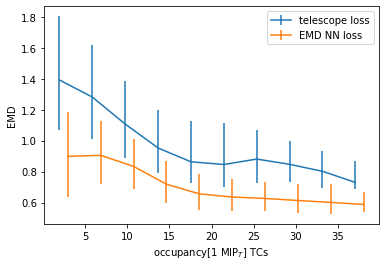

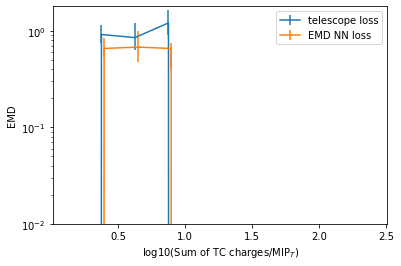

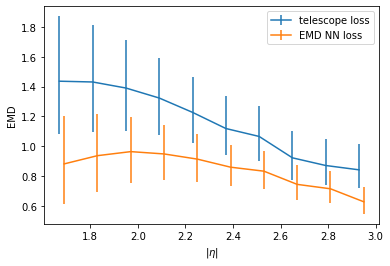

In [83]:
for x_it, x in enumerate((occupancy_1MT, sum_tc_mipt, eta)):
    
    offsets = [0,0.02]
    
    for y_it,y in enumerate((tele_emd, emd_emd)):
        
        nbins=10
        stats=True
        lims = (x.min(),x.max())
        if x_it ==0:
            offsets = [0,1]
        if x_it == 1:
            lims = (0.0,2.5)
            plt.ylim(0.01,1.8)
            plt.yscale('log')
        if x_it == 2:
            lims = (1.6,3.0)
        median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
        lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
        hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
        median = np.nan_to_num(median_result.statistic)
        hi = np.nan_to_num(hi_result.statistic)
        lo = np.nan_to_num(lo_result.statistic)
        hie = hi-median
        loe = median-lo
        bin_edges = median_result.bin_edges
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        
        off = offsets[y_it]

        plt.errorbar(x=bin_centers + off , y=median, yerr=[loe,hie],label = legends[y_it])
    plt.xlabel(x_labels[x_it])
    plt.ylabel('EMD')
    plt.legend()
    plt.savefig(os.path.join(img_directory,image_name[x_it]+'.pdf'),dpi=resolution)
    plt.show()
    plt.close()